<a href="https://colab.research.google.com/github/WilliamShengYangHuang/AA_Research/blob/main/FARMS_MAPPING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. In a fresh cell, install compatible versions:
!pip install --upgrade numpy==1.23.5 scikit-learn==1.2.2

# 2. After that completes, go to Runtime → Restart runtime.


In [21]:
import pandas as pd
import networkx as nx
import folium
import branca
from folium.features import DivIcon, MacroElement
from jinja2 import Template
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib as mpl
import joblib
from IPython.display import display


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

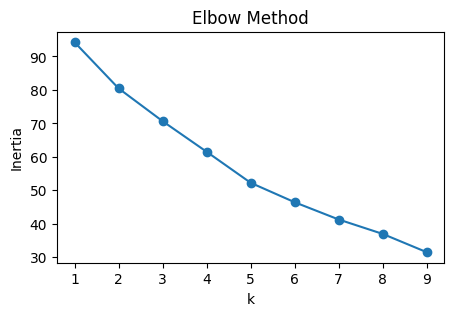

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-29-960b4674d8b5>:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  edge_cmap = mpl.cm.get_cmap('gist_earth', optimal_k)


In [29]:
# ─── Helper: adjust scroll-wheel sensitivity ──────────────────────────
class AdjustWheelZoom(MacroElement):
    _template = Template(u"""
        {% macro script(this, kwargs) %}
        {{this._parent.get_name()}}.options.wheelPxPerZoomLevel = {{this.px}};
        {% endmacro %}
    """)
    def __init__(self, px=240):
        super().__init__()
        self.px = px

# ─── 1. Load survey data ─────────────────────────────────────────────
df = pd.read_excel('farms_long.xlsx')   # ensure this file is present
df['farm_id'] = df.index
df['products_combined'] = (
    df['Products(1)'].fillna('') + ',' + df['Products(2)'].fillna('')
).str.replace('，', ',', regex=False)
df['product_list'] = df['products_combined'].str.split(',').apply(
    lambda lst: [p.strip().lower() for p in lst if p.strip()]
)

# ─── 2. Build co-occurrence matrix ─────────────────────────────────
products = sorted({p for lst in df['product_list'] for p in lst})
cooc = pd.DataFrame(0, index=products, columns=df['farm_id'])
for _, row in df.iterrows():
    for p in row['product_list']:
        cooc.at[p, row['farm_id']] = 1

# ─── 3. Compute product embeddings via SVD ─────────────────────────
svd = TruncatedSVD(n_components=10, random_state=42)
X_emb = svd.fit_transform(cooc.values)

# Save embeddings & model
embeddings_df = pd.DataFrame(
    X_emb,
    index=products,
    columns=[f"emb_{i}" for i in range(1, X_emb.shape[1]+1)]
)
embeddings_df.to_csv("product_embeddings.csv")
joblib.dump(svd, "svd_product_embedding_model.pkl")

# ─── 4. Elbow method for clustering ─────────────────────────────────
inertias = []
for k in range(1, min(len(products), 10)):
    km = KMeans(n_clusters=k, random_state=42).fit(X_emb)
    inertias.append(km.inertia_)
plt.figure(figsize=(5,3))
plt.plot(range(1, len(inertias)+1), inertias, 'o-')
plt.xlabel('k'); plt.ylabel('Inertia'); plt.title('Elbow Method')
plt.show()

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(X_emb)
product2cluster = dict(zip(products, kmeans.labels_))

# ─── 5. Build farm similarity graph ────────────────────────────────
G = nx.Graph()
for _, row in df.iterrows():
    G.add_node(
        row['farm_id'],
        lat=row['lat'],
        lon=row['long'],
        name=row['name'],
        product_list=row['product_list']
    )
for u, du in G.nodes(data=True):
    for v, dv in G.nodes(data=True):
        if u < v:
            shared = sorted(set(du['product_list']) & set(dv['product_list']))
            if shared:
                clusters = [product2cluster[p] for p in shared]
                majority = max(set(clusters), key=clusters.count)
                G.add_edge(u, v, shared=shared, cluster=majority)

# ─── 6. Node centrality & colour scales ────────────────────────────
centrality = nx.degree_centrality(G)
df['centrality'] = df['farm_id'].map(centrality)
min_c, max_c = min(centrality.values()), max(centrality.values())

node_cmap = branca.colormap.LinearColormap(
    ['#adea9e', '#153a0c'],
    vmin=min_c, vmax=max_c,
    caption='Degree Centrality'
)

edge_cmap = mpl.cm.get_cmap('gist_earth', optimal_k)
cluster_colors = {i: mpl.colors.to_hex(edge_cmap(i)) for i in range(optimal_k)}

# ─── 7. Create Folium map with Mapbox Dark ─────────────────────────
MAPBOX_TOKEN = 'pk.eyJ1Ijoid2lsbGlhbS1odWFuZyIsImEiOiJjbTVwZHJscDQwMDRlMmxzZmlsb2VhN2tnIn0.6sFQ1XLj1yZ9LyOXxFd85g'
centre = [df['lat'].mean(), df['long'].mean()]
m = folium.Map(location=centre, zoom_start=10, tiles=None)
folium.TileLayer(
    tiles=(
        f'https://api.mapbox.com/styles/v1/mapbox/dark-v10/tiles/{{z}}/{{x}}/{{y}}'
        f'?access_token={MAPBOX_TOKEN}'
    ),
    attr='Mapbox',
    name='Mapbox Dark',
    overlay=False,
    control=True
).add_to(m)

# Adjust wheel zoom sensitivity
m.add_child(AdjustWheelZoom(px=240))

# ─── 8. Draw geodesic edges coloured by cluster ─────────────────────
for u, v, data in G.edges(data=True):
    lat1, lon1 = G.nodes[u]['lat'], G.nodes[u]['lon']
    lat2, lon2 = G.nodes[v]['lat'], G.nodes[v]['lon']
    folium.PolyLine(
        locations=[(lat1, lon1), (lat2, lon2)],
        weight=2,
        color=cluster_colors[data['cluster']],
        opacity=0.7,
        tooltip=(f"{G.nodes[u]['name']} ↔ {G.nodes[v]['name']}<br>"
                 f"Shared products: {', '.join(data['shared'])}"),
        geodesic=True
    ).add_to(m)

# ─── 9. Add farm points, popups & labels ───────────────────────────
for _, row in df.iterrows():
    popup_html = (
        f"<b>{row['name']}</b><br>"
        f"Coordinates: {row['lat']:.5f}, {row['long']:.5f}<br>"
        "Products: " + ", ".join(row['product_list'])
    )
    folium.CircleMarker(
        location=(row['lat'], row['long']),
        radius=6,
        fill=True,
        fill_color=node_cmap(row['centrality']),
        color='black',
        weight=0.5,
        fill_opacity=0.9,
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(m)
    folium.map.Marker(
        location=(row['lat'], row['long']),
        icon=DivIcon(
            icon_size=(150, 16),
            icon_anchor=(0, 0),
            html=(f'<div style="font-family:\'Calibri Light\',sans-serif; '
                  f'font-size:8px; color:silver;">{row["name"]}</div>')
        )
    ).add_to(m)

# ─── 10. Inject Leaflet.easyPrint plugin & Add export button ────────
easyprint_js = """
<script src="https://rawcdn.githack.com/rowanwins/leaflet-easyPrint/2.1.9/bundled/leaflet.easyPrint.min.js"></script>
<script>
// add export control
var printer = L.easyPrint({
    tileLayer: m.getPanes().tilePane,
    sizeModes: ['Current'],
    filename: 'farm_network_map',
    exportOnly: true
}).addTo(m);
</script>
"""
m.get_root().html.add_child(folium.Element(easyprint_js))

# ─── 11. Add legends & display ────────────────────────────────────
node_cmap.add_to(m)
legend_html = """
<div style="position:fixed;bottom:10px;right:10px;
            background:white;padding:5px;border:1px solid gray;z-index:9999;">
  <b>Edge clusters</b><br>
"""
for i in range(optimal_k):
    legend_html += (
        f'<i style="background:{cluster_colors[i]};width:10px;'
        'height:10px;display:inline-block;margin-right:5px;"></i>'
        f'Cluster {i}<br>'
    )
legend_html += "</div>"
m.get_root().html.add_child(folium.Element(legend_html))

# Display
display(m)
